In [1]:
import pandas as pd
import pyro
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# some comments
pyro.set_rng_seed(101)

In [3]:
%matplotlib inline

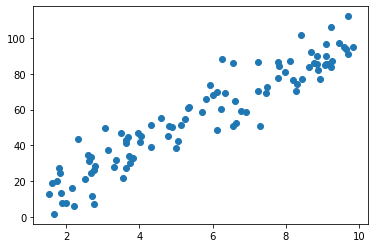

In [41]:
# Generate items
# For now, items described by single attribute - quality
# Each item has a list price determined by that quality
num_items = torch.tensor(100)
item_quality = torch.distributions.Uniform(1, 10).sample([100])
#pyro.sample("item_quality", pyro.distributions.Uniform(1, 10).expand([num_items,]))
list_price = torch.maximum(torch.distributions.Normal(item_quality, torch.tensor(1.0)).sample(),torch.tensor(0.0)) * 10
plt.scatter(item_quality, list_price)
mean_quality = torch.mean(item_quality)
mean_list_price = torch.mean(list_price)

In [42]:
# Generate customers
# Each customer has a view on the value of item quality which determines their willingness to pay
num_cust = torch.tensor(10000)
beta_quality_loc = torch.log(pyro.sample("beta_quality_loc", pyro.distributions.Uniform(5,10)))
beta_quality_scale = torch.log(pyro.sample("beta_quality_scale", pyro.distributions.Uniform(1,2)))
beta_quality = pyro.sample("beta_quality", pyro.distributions.LogNormal(beta_quality_loc, beta_quality_scale).expand([num_cust,]))
mean_beta_quality = torch.mean(beta_quality)
std_beta_quality = torch.std(beta_quality)

#wtp_loc = torch.log(pyro.sample("wtp_mean", pyro.distributions.Uniform(10,20)))
#wtp_scale = torch.log(pyro.sample("wtp_scale", pyro.distributions.Uniform(1,3)))
#print(torch.exp(wtp_loc))
#print(torch.exp(wtp_scale))


#wtp = pyro.sample("wtp", pyro.distributions.LogNormal(wtp_loc, wtp_scale).expand([num_cust,]))
#mean_wtp = torch.mean(wtp)
#std_wtp = torch.std(wtp)

# Generate salespeople
num_sales = torch.tensor(2)
sales_wtp_bias = pyro.sample("sales_wtp_bias", pyro.distributions.Uniform(-0.2,0.1).expand([num_sales,]))
sales_wtp_uncertainty = pyro.sample("sales_wtp_uncertainty", pyro.distributions.Uniform(0.1,0.3).expand([num_sales,]))

#list_price = torch.quantile(wtp,torch.tensor([0.9])).squeeze().item()


# Generate quotes
## One per customer, randomly assign an item and a ssalesperson to each customer
## Negotiate.  Salesperson 
# Either won with price recorded or lost with price not recorded.

outcome = {}
for c in range(num_cust):
    s = random.randrange(num_sales)
    i = random.randrange(num_items)
    wtp = item_quality[i] * beta_quality[c]
    est_wtp = pyro.sample("estimated_wtp", pyro.distributions.Normal(wtp*(1+sales_wtp_bias[s]), wtp*sales_wtp_uncertainty[s]))
    #est_wtp = pyro.sample("estimated_wtp", pyro.distributions.Normal(wtp[c]*(1+sales_wtp_bias[s]), wtp[c]*sales_wtp_uncertainty[s]))
    if wtp.item() >= list_price[i].item():
        result = 1
        price = list_price[i].item()
    if wtp.item() < est_wtp:
        result = 0
        price = np.nan
    else:
        result = 1
        price = ( est_wtp.item() + wtp.item() ) /2
    outcome[c] = {'result':result, 'price':price, 'wtp':wtp.item(), 'est_wtp':est_wtp.item(), 'salesperson':s}



In [43]:
df = pd.DataFrame.from_dict(outcome, orient='index')

In [44]:
df

,result,price,wtp,est_wtp,salesperson
0,1,48.959425,53.393116,44.525734,1
1,0,NaN,55.234478,74.075890,1
2,1,13.487222,16.690929,10.283515,1
3,1,31.241411,34.416615,28.066208,0
4,1,51.493631,61.444942,41.542320,1
...,...,...,...,...,...
9995,0,NaN,18.754353,20.639214,1
9996,1,57.783966,64.142532,51.425400,0
9997,0,NaN,130.031982,174.425827,0
9998,0,NaN,20.784847,20.833910,0


In [45]:
df.describe()

,result,price,wtp,est_wtp,salesperson
count,10000.000000,6383.000000,10000.000000,10000.000000,10000.000000
mean,0.638300,42.591381,47.263335,43.411083,0.501000
std,0.480517,24.585001,26.941120,27.439961,0.500024
min,0.000000,4.125913,5.102670,-1.544521,0.000000
25%,0.000000,23.067018,25.649299,22.290218,0.000000
50%,1.000000,38.488941,42.938320,37.372992,1.000000
75%,1.000000,57.422760,63.589742,58.925856,1.000000
max,1.000000,165.957382,199.931549,221.671967,1.000000


In [8]:
# Distribution of price-like variables

list_price.item()

AttributeError: 'float' object has no attribute 'item'

In [ ]:
# Comparison of list price, wtp, estimated wtp, agreed price (if any) for sample of customers
# Random sample X, sort by wtp ascendin

In [ ]:
# Distribution of discounts on won deals by salesperson

In [ ]:
# Conversion rate by discount on won deals

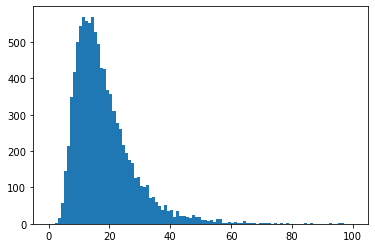

In [23]:
_ = plt.hist(wtp.numpy(), 100, (0, 100))


In [ ]:
z = wtp.numpy()

(array([9., 0., 1.]),
 array([ 1., 23., 45., 67.]),
 <BarContainer object of 3 artists>)

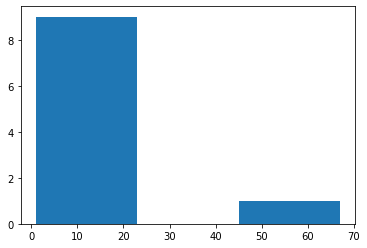

In [5]:
x = [1, 2, 3, 4, 5, 67, 8, 9, 20, 21]
nb=3
plt.hist(x, nb)
#plt.show();